In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Dropout
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

2023-11-16 15:32:41.583019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


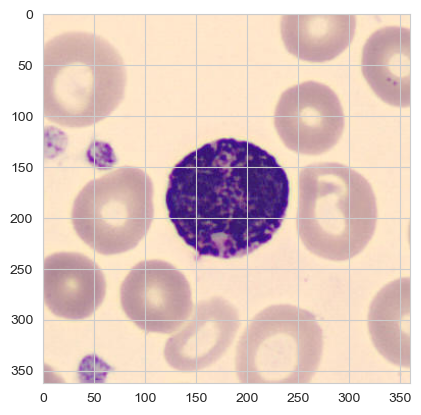

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


In [2]:
# Einlesen eines Bildes
img = mpimg.imread('images/archive/bloodcells_dataset/basophil/BA_47.jpg')
imgplot = plt.imshow(img)
plt.show()

# Daten einlesen
image_size = (224, 224)
batch_size = 32
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    "images/archive/bloodcells_dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)
X_test = tf.keras.preprocessing.image_dataset_from_directory(
    "images/archive/bloodcells_dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

In [3]:
# Daten vorbereiten
train_ds = X_train.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = X_test.prefetch(buffer_size=tf.data.AUTOTUNE)


# Die Gewichte des ResNet50 freezen
resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3))
resnet50.trainable = False

# Transfer Learning Model aufbauen
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model.add(keras.layers.experimental.preprocessing.RandomRotation(0.1))
model.add(keras.layers.experimental.preprocessing.Rescaling(1.0 / 255) )
model.add(resnet50)

# Eigener Decision Bereich
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
#model.add(Dropout(0.3))  # Dropout für Regularisierung
model.add(Dense(16, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

# Modell kompilieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy", metrics=["accuracy"])

# Zusammenfassung des Modells anzeigen
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                        

In [4]:
# Frühes Stoppen
fruehes_stoppen = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", min_delta=0.005)

# Modell trainieren
history1 = model.fit(train_ds, epochs=1, batch_size=50, validation_data=val_ds, callbacks=[fruehes_stoppen])

history2 = model.fit(train_ds, epochs=1, batch_size=50, validation_data=val_ds, callbacks=[fruehes_stoppen])

428/428 [==============================] - 2358s 6s/step - loss: 2.0111 - accuracy: 0.1954 - val_loss: 2.0158 - val_accuracy: 0.1922


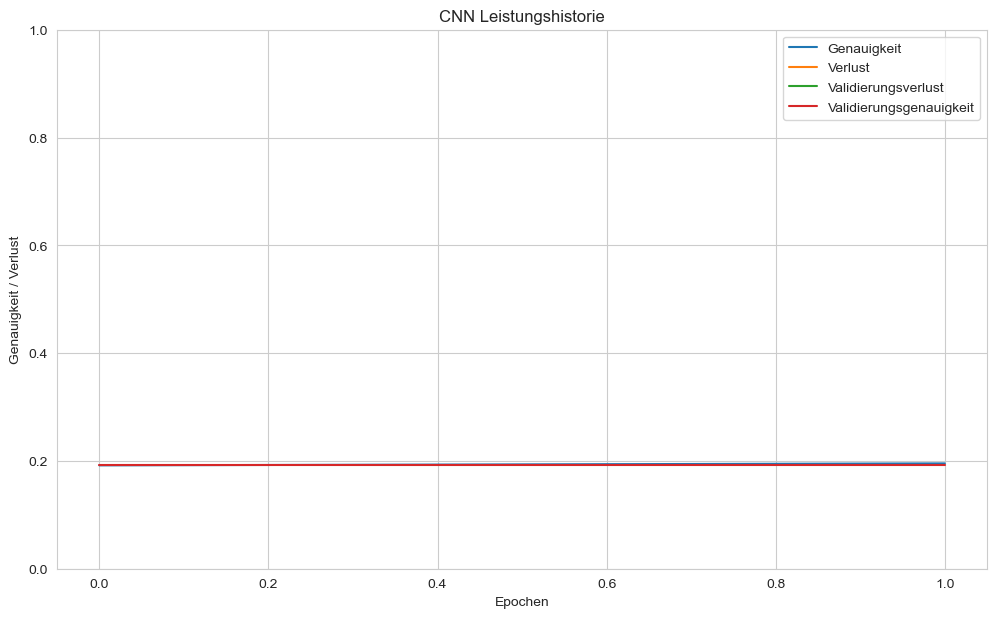

107/107 [==============================] - 375s 4s/step - loss: 2.0158 - accuracy: 0.1922


[2.0158097743988037, 0.19221767783164978]

In [5]:
# Historien kombinieren
combined_history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
}

# Kombinierte Historie plotten
x = range(0, len(combined_history['accuracy']))
plt.figure(figsize=(12, 7))
sns.lineplot(x=x, y=combined_history['accuracy'], label='Genauigkeit')
sns.lineplot(x=x, y=combined_history['loss'], label='Verlust')
sns.lineplot(x=x, y=combined_history['val_loss'], label='Validierungsverlust')
sns.lineplot(x=x, y=combined_history['val_accuracy'], label='Validierungsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit / Verlust')
plt.title('CNN Leistungshistorie')
plt.ylim(0, 1)
plt.show()

# Evaluation auf dem Validierungsdatensatz
model.evaluate(val_ds)

In [6]:
# Modell speichern
model.save("transfer_learning_resnet.h5")

/Users/retosutter/opt/anaconda3/envs/DS2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# Jetzt Produktion
from keras.models import load_model
model_loaded = load_model('transfer_learning_resnet.h5')

# Beispielvorhersagen
img = keras.preprocessing.image.load_img("images/archive/bloodcells_dataset/erythroblast/ERB_5435.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predict = model_loaded.predict(img_array)
print(predict)

1/1 [==============================] - 2s 2s/step
[[0.08309857 0.16845217 0.09519146 0.16112256 0.08328437 0.09289888
  0.17925161 0.1367004 ]]
